In [3]:
!pip install pybbn

  Using cached https://files.pythonhosted.org/packages/16/b5/bab3477466a4d9e705d40829ac65683155e7977acbc07f05b06fabded1be/pandas-0.25.3-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c3/8b/af9e0984f5c0df06d3fab0bf396eb09cbf05f8452de4e9502b182f59c33b/matplotlib-3.1.1-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
     |████████████████████████████████| 122kB 1.7MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/e7/f9/f0b53f88060247251bf481fa6ea62cd0d25bf1b11a87888e53ce5b7c8ad2/pytz-2019.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/df/93/8bc9b52a8846be2b9572aa0a7c881930939b06e4abe1162da6a0430b794f/kiwisolver-1.1.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
     |████████████████████████████████| 71kB 5.6MB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/p

In [4]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [10]:
# create the nodes
season = BbnNode(Variable(0, 'season', ['winter', 'summer']), [0.5, 0.5])
atmos_pres = BbnNode(Variable(1, 'atmos_press', ['high', 'low']), [0.5, 0.5])
allergies = BbnNode(Variable(2, 'allergies', ['allergic', 'non_alergic']), [0.7, 0.3, 0.2, 0.8])
rain = BbnNode(Variable(3, 'rain', ['rainy', 'sunny']), [0.9, 0.1, 0.7, 0.3, 0.3, 0.7, 0.1, 0.9])
grass = BbnNode(Variable(4, 'grass', ['grass', 'no_grass']), [0.8, 0.2, 0.3, 0.7])
umbrellas = BbnNode(Variable(5, 'umbrellas', ['on', 'off']), [0.99, 0.01, 0.80, 0.20, 0.20, 0.80, 0.01, 0.99])
dog_bark = BbnNode(Variable(6, 'dog_bark', ['bark', 'not_bark']), [0.8, 0.2, 0.1, 0.9])
cat_mood = BbnNode(Variable(7, 'cat_mood', ['good', 'bad']), [0.05, 0.95, 0.95, 0.05])
cat_hide = BbnNode(Variable(8, 'cat_hide', ['hide', 'show']), [0.20, 0.80, 0.95, 0.05, 0.95, 0.05, 0.70, 0.30])

bbn = Bbn() \
    .add_node(season) \
    .add_node(atmos_pres) \
    .add_node(allergies) \
    .add_node(rain) \
    .add_node(grass) \
    .add_node(umbrellas) \
    .add_node(dog_bark) \
    .add_node(cat_mood) \
    .add_node(cat_hide) \
    .add_edge(Edge(season, allergies, EdgeType.DIRECTED)) \
    .add_edge(Edge(season, umbrellas, EdgeType.DIRECTED)) \
    .add_edge(Edge(season, rain, EdgeType.DIRECTED)) \
    .add_edge(Edge(atmos_pres, rain, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, grass, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, umbrellas, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, dog_bark, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, cat_mood, EdgeType.DIRECTED)) \
    .add_edge(Edge(dog_bark, cat_hide, EdgeType.DIRECTED)) \
    .add_edge(Edge(cat_mood, cat_hide, EdgeType.DIRECTED))

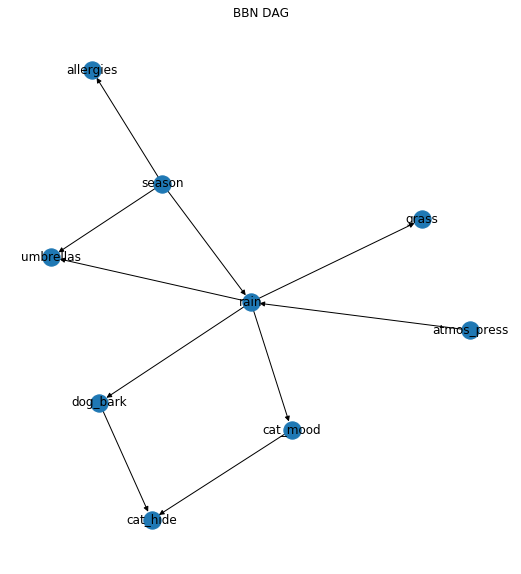

In [11]:
%matplotlib inline
from pybbn.generator.bbngenerator import convert_for_drawing
import matplotlib.pyplot as plt
import networkx as nx
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(20, 10))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')

In [26]:
# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

# insert an observation evidence
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('season')) \
    .with_evidence('winter', 1.0) \
    .build()

join_tree.set_observation(ev)

# print the marginal probabilities
for node in join_tree.get_bbn_nodes():
    potential = join_tree.get_bbn_potential(node)
    print(node)
    print(potential)
    print('--------------------->')

0|season|winter,summer
0=winter|1.00000
0=summer|0.00000
--------------------->
2|allergies|allergic,non_alergic
2=allergic|0.70000
2=non_alergic|0.30000
--------------------->
3|rain|rainy,sunny
3=rainy|0.80000
3=sunny|0.20000
--------------------->
4|grass|grass,no_grass
4=grass|0.70000
4=no_grass|0.30000
--------------------->
1|atmos_press|high,low
1=high|0.50000
1=low|0.50000
--------------------->
5|umbrellas|on,off
5=on|0.95200
5=off|0.04800
--------------------->
6|dog_bark|bark,not_bark
6=bark|0.66000
6=not_bark|0.34000
--------------------->
7|cat_mood|good,bad
7=good|0.23000
7=bad|0.77000
--------------------->
8|cat_hide|hide,show
8=hide|0.87150
8=show|0.12850
--------------------->


In [28]:
# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

# insert an observation evidence
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('season')) \
    .with_evidence('winter', 1.0) \
    .build()

ev2 = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('dog_bark')) \
    .with_evidence('not_bark', 1.0) \
    .build()

join_tree.set_observation(ev)
join_tree.set_observation(ev2)

# print the marginal probabilities
for node in join_tree.get_bbn_nodes():
    potential = join_tree.get_bbn_potential(node)
    print(node)
    print(potential)
    print('--------------------->')

0|season|winter,summer
0=winter|1.00000
0=summer|0.00000
--------------------->
2|allergies|allergic,non_alergic
2=allergic|0.70000
2=non_alergic|0.30000
--------------------->
3|rain|rainy,sunny
3=rainy|0.47059
3=sunny|0.52941
--------------------->
4|grass|grass,no_grass
4=grass|0.53529
4=no_grass|0.46471
--------------------->
1|atmos_press|high,low
1=high|0.39706
1=low|0.60294
--------------------->
5|umbrellas|on,off
5=on|0.88941
5=off|0.11059
--------------------->
6|dog_bark|bark,not_bark
6=bark|0.00000
6=not_bark|1.00000
--------------------->
7|cat_mood|good,bad
7=good|0.52647
7=bad|0.47353
--------------------->
8|cat_hide|hide,show
8=hide|0.83162
8=show|0.16838
--------------------->
